# Fitting Pulse Shapes

In this tutorial, you will learn how to fit the pulse shapes that you get from a photomultiplier tube (PMT) using the [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function from [scipy](https://scipy-cookbook.readthedocs.io/).

The goal is primarily to find the time constants for the falling rising edges to characerize a PMT with an anorganic szintillator.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

## Visualizing Pulse Shapes

Let's first read the waveforms file from the Oscilloscope. We have to skip the first two rows, as they only contain some meta information.

In [2]:
df = pd.read_csv("signal.csv", skiprows=15)
df.columns = ["data"]
df["voltage"] = df["data"] * 0.002/5. # in Volt
df["time"] = np.arange(len(df), dtype=np.float) * 2.5e-7 # in seconds

We can plot the pulse from the dataframe like this:

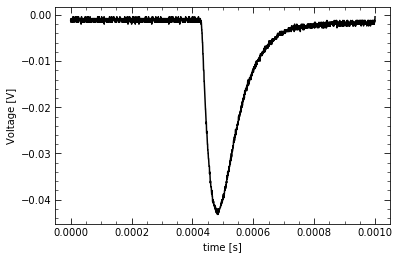

In [3]:
plt.plot(df["time"], df["voltage"],'k')
plt.xlabel(r"time [s]")
plt.ylabel("Voltage [V]")
plt.show()

That looks alright! But for the studies we want to do now, it's easier to renormalize the data a bit so we can fit it easier. After all, we are only interested in the time scales, so we:

* convert the time to $\mu$s
* define $t = 0$ to be the beginning of the pulse
* rescale the voltage such that zero is the baseline, and one is the peak maximum

In [4]:
time = df["time"].values
voltage = df["voltage"].values

time = ((time - time[np.argmin(voltage)]) * 1e6) + 55 # now in microseconds
voltage = voltage - np.mean(voltage[time < 0])
voltage = voltage / np.min(voltage)

It now looks like this, if we restrict the plot range to the interesting time window:

In [5]:
def plot_pulse(xlim=None):
    plt.plot(time, voltage,'k', label='data')
    plt.xlabel(r"time [$\mu$s]")
    plt.ylabel("Voltage")
    plt.ylim(-0.05, 1.05)
    if not xlim is None:
        plt.xlim(*xlim)
    plt.legend()

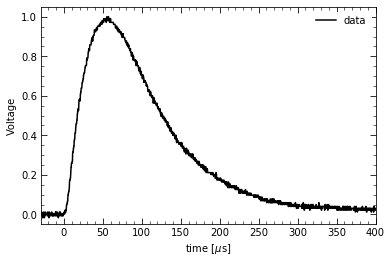

In [6]:
plot_pulse(xlim=(-30, 400))
plt.show()

## Fitting Rise Time and Fall Time

In a first attempt to obtain the time scales of the pulse, we will fit exponentials to the rising and falling edge individually. Let's define two functions that we are going to fit:

In [7]:
def f_rise(x, tau, mu):
    return 1-np.exp(-(x - mu)/tau)

def f_fall(x, tau, mu):
    return np.exp(-(x - mu)/tau)

The functions that we'll use for fitting need to take the x-axis values as a first argument, and then the function parameters as remaining arguments.

Let's plot the functions with some first guesses for the parameters:

* we know from the literature that the fall-time is expected to be about 100 μs
* the decay starts about 50 μs after the pulse start
* the rise-time is maybe an order of magnitude faster than the fall-time, so let's take 10 μs

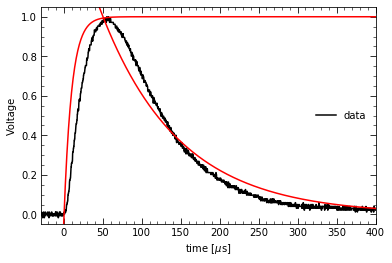

In [8]:
plot_pulse(xlim=(-30, 400))
x = np.linspace(time[0], time[-1], 2000)
plt.plot(x, f_rise(x, tau=10., mu=0.), 'r')
plt.plot(x, f_fall(x, tau=100., mu=50.), 'r')
plt.legend()
plt.show()

In [9]:
rise_interval = (5, 30)
fall_interval = (100, 400)

In [10]:
selection_rise = np.logical_and(time > rise_interval[0], time < rise_interval[1])
popt_rise, pcov_rise = curve_fit(f_rise, time[selection_rise], voltage[selection_rise], p0=[10., 0.])
puncert_rise = np.sqrt(np.diag(pcov_rise))

In [11]:
selection_fall = np.logical_and(time > fall_interval[0], time < fall_interval[1])
popt_fall, pcov_fall = curve_fit(f_fall, time[selection_fall], voltage[selection_fall], p0=[100., 50.])
puncert_fall = np.sqrt(np.diag(pcov_fall))

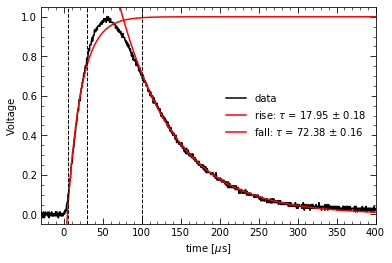

In [12]:
plot_pulse(xlim=(-30, 400))
plt.plot(x, f_rise(x, *popt_rise), 'r',
         label=r'rise: $\tau$ = {0:0.2f} ± {1:0.2f}'.format(popt_rise[0], puncert_rise[0]))
plt.plot(x, f_fall(x, *popt_fall), 'r',
         label=r'fall: $\tau$ = {0:0.2f} ± {1:0.2f}'.format(popt_fall[0], puncert_fall[0]))
plt.plot(2*[rise_interval[0]], plt.ylim(), 'k--', linewidth=1)
plt.plot(2*[rise_interval[1]], plt.ylim(), 'k--', linewidth=1)
plt.plot(2*[fall_interval[0]], plt.ylim(), 'k--', linewidth=1)
plt.plot(2*[fall_interval[1]], plt.ylim(), 'k--', linewidth=1)
plt.legend()
plt.show()

## Creating Convolution of Functions

In truth, the pulse shape is of course characterized by the convolution of different effects which have to be considered together.

To fit the convolution of two functions to the data, we first have to know how to create the convolution of two functions. Naively, this can be done in quadratic time, but this gets a bit slow when the function is evaluated often, as is done in the `curve_fit` routine.

Therefore, it's better to use the [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (FFT) algorithm, which has compexity $N\log{N}$. In Fourier space, the convolution of the original functions is just the product. This is implemented for us in [`scipy.signal.fftconvolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html).

Below, I implemented a little function that returns a function which behaves as the convolution of two functions:

In [13]:
from scipy.signal import fftconvolve

def fconv(f, g):
    def h(x):
        """Input x has to be equidistant!
        """
        # Do some trickery to evaluate the convolution at the desired x-values.
        n = len(x)
        d = x[1] - x[0]
        x_ext = np.concatenate([x[-n//2:] - n*d, x, x[:n//2] + n*d])
        res = fftconvolve(f(x_ext), g(x_ext), mode='full') * (x_ext[1] - x_ext[0])
        return np.interp(x, x_ext*2, res[::2])
    return h

Please remember that the output of the convolution function will be invalid if the support of either $f$ or $g$ extends outside the range `x`, i.e. if any of the functions has non-zero values outside `x`.

We can test this for example with a square pulse and a Gaussian:

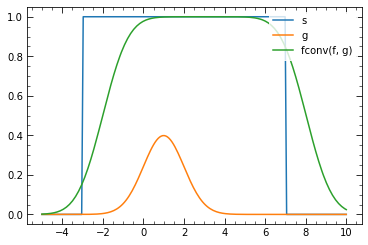

In [14]:
def s(x):
    return 0. + np.logical_and(x > -3, x < 7)
def g(x, sigma=1.):
    return 1./(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-1)/sigma)**2)
h = fconv(s, g)

x = np.linspace(-5, 10, 200)
plt.plot(x, s(x), label="s")
plt.plot(x, g(x), label="g")
plt.plot(x, h(x), label="fconv(f, g)")
plt.legend(loc="upper right")
plt.show()

## Fitting the Full Pulse Shape

We can now be more ambitious and try to fit the full pulse shape. In this tutorial, I will propose a simple model, but feel free to extend it to account for more effects.

Since the characteristic time an anorganic scintillator is rather long, one component of our model will be an exponential decay:

In [15]:
def f_scint(x, tau=100.):
    return (x > 0.) * np.clip(np.exp(-x/tau), 0, 1)

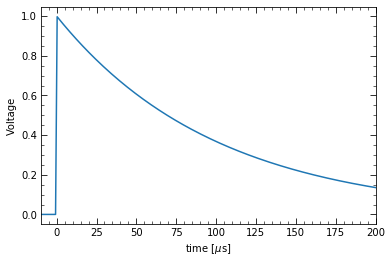

In [16]:
x = np.linspace(time[0], time[-1], 1000)
plt.plot(x, f_scint(x, tau=100.))
plt.xlabel(r"time [$\mu$s]")
plt.ylabel("Voltage")
plt.xlim(-10, 200)
plt.show()

The exponential decay has to be convoluted with the response of the electronic circuit in the PMT, which we model as a simple $RC$ circuit.

As a start, we can make the crude assumption that for each scintillating photon hitting the photocathod, we'll get a square pulse of electrons at the anode. Therefore, the second component of the model is a square pulse of a certain width whose flanks have been smoothed. This results in the typical "shark fin pulse":

In [17]:
def f_rc(x, tau=10., width=50.):
    rise = (x < width) * np.clip(-np.exp(-x/tau) + 1, 0, 1)
    high = np.max(rise)
    fall = high * (x >= width) * np.clip(np.exp(-(x - width)/tau), 0, 1)
    return rise + fall

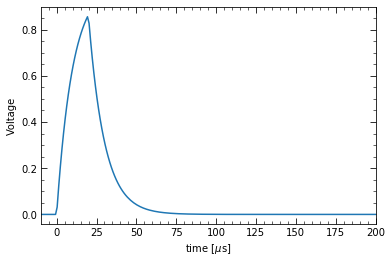

In [18]:
plt.plot(x, f_rc(x, tau=10., width=20))
plt.xlabel(r"time [$\mu$s]")
plt.ylabel("Voltage")
plt.xlim(-10, 200)
plt.show()

Our final model function evaluates the convolution of both `f_rc` and `f_scint`:

In [19]:
def f_model(x, tau, rc_tau, rc_width):
    f1 = lambda x : f_rc(x, tau=rc_tau, width=rc_width)
    f2 = lambda x : f_scint(x, tau=tau)
    
    res = fconv(f1, f2)(x)
    
    # normalize such that the peak has maximum value 1
    return res / np.max(res)

Finally, we fit the model function to the data with `curve_fit`:

In [20]:
popt, pcov = curve_fit(f_model, time, voltage, p0=[100, 10, 20])
puncert = np.sqrt(np.diag(pcov))

Let's see the result of the fit and the individual model components before the convolution:

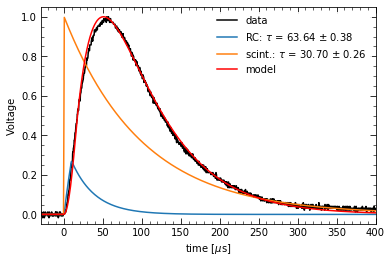

In [21]:
plot_pulse(xlim=(-30, 400))
plt.plot(x, f_rc(x, tau=30., width=10.),
         label=r'RC: $\tau$ = {0:0.2f} ± {1:0.2f}'.format(popt[0], puncert[0]))
plt.plot(x, f_scint(x, tau=100.),
         label=r'scint.: $\tau$ = {0:0.2f} ± {1:0.2f}'.format(popt[1], puncert[1]))
plt.plot(x, f_model(x, *popt), 'r',
         label='model')
plt.legend()
plt.xlabel(r"time [$\mu$s]")
plt.ylabel("Voltage")
plt.show()

Now, the characteristic time of the $RC$ circuit is also considered in the falling edge, therefore the characteristic time of the scintillator is a bit smaller than the decay-time we obtained when we were fitting only the falling edge with an exponential.

## Conclusion

**In this tutorial you have learned how to**:

* load waveforms data from `.csv` files and visualize them
* fit simple functions to subsets of the data
* create the convolution of two functions
* fit the convolution of two functions
    
**What you could do now**:
    
* Improve the model to be more realistic and take into account more effects
* If you work with organic scintillators, adapt the model to this kind of scintillators